<a href="https://colab.research.google.com/github/kelvinlo-yuhsiang/firstproject/blob/main/Python_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#載入 Keras

In [ ]:
import os
import sys
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, Lambda, RepeatVector
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

#載入股價data

In [ ]:
import datetime
import requests
import pandas as pd
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
    "dataset": "TaiwanStockPrice",
    "data_id": "2330",
    "start_date": "2018-09-26",
    "end_date": "2021-09-26",
    "token": "", # 參考登入，獲取金鑰
}
resp = requests.get(url, params=parameter)
data = resp.json()
df_2330 = pd.DataFrame(data["data"])
df_2330.to_csv('/content/df_2330.csv', encoding = "utf-8",index=False)
print(df_2330.head())

data=df_2330[["open","max","min","close","Trading_Volume"]]
#data=df_all[["Open","High","Low","Close","Volume","TWII"]]
data.to_csv('/content/data.csv', encoding = 'utf-8', index=False)
data=pd.read_csv('/content/data.csv', encoding = "utf-8")
print(data)

         date stock_id  Trading_Volume  ...  close  spread  Trading_turnover
0  2018-09-26     2330        25061115  ...  263.5     0.0              7007
1  2018-09-27     2330        38495371  ...  265.0     1.5             11536
2  2018-09-28     2330        39645486  ...  262.5    -2.5             13060
3  2018-10-01     2330        22409380  ...  263.0     0.5             11914
4  2018-10-02     2330        38391491  ...  257.5    -5.5             17095

[5 rows x 10 columns]
      open    max    min  close  Trading_Volume
0    263.0  263.5  261.0  263.5        25061115
1    264.0  266.0  262.0  265.0        38495371
2    266.0  266.0  260.0  262.5        39645486
3    262.0  264.0  261.0  263.0        22409380
4    262.0  263.0  257.0  257.5        38391491
..     ...    ...    ...    ...             ...
720  622.0  627.0  612.0  619.0        38713621
721  612.0  620.0  610.0  619.0        19309522
722  615.0  623.0  614.0  622.0        16740439
723  619.0  620.0  613.0  615.0    

#資料正規化

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

# read data from csv, return data: (Samples, feature)
#data = file_processing('20180525_50.csv')

feature_len = data.shape[1]

# normalize data
minmaxscaler = scaler.fit(data)
data = minmaxscaler.transform(data)

print(data)

[[0.11381215 0.11122995 0.12017641 0.11935484 0.11903678]
 [0.1160221  0.11657754 0.12238148 0.12258065 0.19949467]
 [0.12044199 0.11657754 0.11797133 0.1172043  0.20638272]
 ...
 [0.89171271 0.8802139  0.8985667  0.89032258 0.06920416]
 [0.90055249 0.87379679 0.89636163 0.87526882 0.06363036]
 [0.89834254 0.86951872 0.89415656 0.87096774 0.064919  ]]


#把資料切成 train 與 validation

In [ ]:
#學習過去幾天
time_step=20

after_day=1
#20% 小考
#80% 教學
validate_percent=0.8

seq_length = time_step + after_day
#21 天(21筆)資料切成 一分

result = []
for index in range(len(data) - seq_length + 1):
    result.append(data[index: index + seq_length])
    

#表格變成矩陣
result = np.array(result)
print('total data: ', result.shape)
#total data:  (709, 21, 5)

train_size = int(len(result) * validate_percent)
train = result[:train_size, :]
#0.8學習
validate = result[train_size:, :]
#0.2考試

x_train = train[:, :time_step]
y_train = train[:, time_step:]
x_validate = validate[:, :time_step]
y_validate = validate[:, time_step:]

# test data
x_test = data[-time_step:]
x_test = np.reshape(x_test, (1, x_test.shape[0], x_test.shape[1]))

print('train data: ', x_train.shape, y_train.shape)
print('validate data: ', x_validate.shape, y_validate.shape)

total data:  (705, 21, 5)
train data:  (564, 20, 5) (564, 1, 5)
validate data:  (141, 20, 5) (141, 1, 5)


In [ ]:
#過去20筆數據
x_train[110,:,:]

array([[0.06077348, 0.05882353, 0.06063947, 0.05698925, 0.07244372],
       [0.05635359, 0.05989305, 0.06394708, 0.06666667, 0.17582226],
       [0.06187845, 0.0631016 , 0.07166483, 0.07096774, 0.13089152],
       [0.06077348, 0.06203209, 0.06945976, 0.06989247, 0.05650489],
       [0.06740331, 0.06524064, 0.07276736, 0.07311828, 0.10702795],
       [0.06850829, 0.07272727, 0.07607497, 0.08064516, 0.13373014],
       [0.08066298, 0.07914439, 0.08379272, 0.08709677, 0.10667158],
       [0.0640884 , 0.0684492 , 0.07497244, 0.07204301, 0.08437322],
       [0.06961326, 0.06951872, 0.07607497, 0.07741935, 0.09503315],
       [0.06740331, 0.06631016, 0.07497244, 0.07204301, 0.11041843],
       [0.0640884 , 0.06631016, 0.0738699 , 0.07311828, 0.05277999],
       [0.06961326, 0.07272727, 0.07497244, 0.08064516, 0.15475341],
       [0.08729282, 0.08449198, 0.08489526, 0.08064516, 0.18054116],
       [0.0839779 , 0.08128342, 0.08710033, 0.08172043, 0.119803  ],
       [0.08287293, 0.0802139 , 0.

In [ ]:
y_train[110,:,:]

array([[0.0961326 , 0.09518717, 0.1047409 , 0.10215054, 0.07229786]])

#建立模型

In [ ]:
#過去天數
def base_model(feature_len=1, after_day=1, input_shape=(30, 1)):
    model = Sequential()

    model.add(LSTM(units=200, return_sequences=False, input_shape=input_shape))
    #model.add(LSTM(units=100, return_sequences=False, input_shape=input_shape))

    model.add(Dropout(0.1))

    # one to many
    model.add(RepeatVector(after_day))
    model.add(LSTM(200, return_sequences=True))
    #model.add(LSTM(50, return_sequences=True))

    model.add(Dropout(0.1))
    model.add(TimeDistributed(Dense(units=feature_len, activation='linear')))

    return model

# model complie
input_shape = (time_step, feature_len)
model = base_model(feature_len, after_day, input_shape)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               164800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 200)            320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 200)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 5)              1005      
Total params: 486,605
Trainable params: 486,605
Non-trainable params: 0
__________________________________________________

#開始 training

In [ ]:
batch_size = 64
epochs = 100

model_name="first_RNN"
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_validate, y_validate), verbose=2)

file_path = 'model/{}.h5'.format(model_name)
if not os.path.exists(os.path.dirname(file_path)):
    try:
        os.makedirs(os.path.dirname(file_path))
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise


train_predict = model.predict(x_train)
validate_predict = model.predict(x_validate)
test_predict = model.predict(x_test)


Epoch 1/100
9/9 - 9s - loss: 0.0584 - val_loss: 0.0308
Epoch 2/100
9/9 - 1s - loss: 0.0121 - val_loss: 0.0102
Epoch 3/100
9/9 - 1s - loss: 0.0063 - val_loss: 0.0162
Epoch 4/100
9/9 - 1s - loss: 0.0048 - val_loss: 0.0056
Epoch 5/100
9/9 - 1s - loss: 0.0044 - val_loss: 0.0062
Epoch 6/100
9/9 - 1s - loss: 0.0041 - val_loss: 0.0054
Epoch 7/100
9/9 - 1s - loss: 0.0041 - val_loss: 0.0078
Epoch 8/100
9/9 - 1s - loss: 0.0039 - val_loss: 0.0058
Epoch 9/100
9/9 - 1s - loss: 0.0039 - val_loss: 0.0064
Epoch 10/100
9/9 - 1s - loss: 0.0038 - val_loss: 0.0102
Epoch 11/100
9/9 - 1s - loss: 0.0039 - val_loss: 0.0072
Epoch 12/100
9/9 - 1s - loss: 0.0038 - val_loss: 0.0043
Epoch 13/100
9/9 - 1s - loss: 0.0036 - val_loss: 0.0047
Epoch 14/100
9/9 - 1s - loss: 0.0037 - val_loss: 0.0051
Epoch 15/100
9/9 - 1s - loss: 0.0036 - val_loss: 0.0045
Epoch 16/100
9/9 - 1s - loss: 0.0035 - val_loss: 0.0075
Epoch 17/100
9/9 - 1s - loss: 0.0035 - val_loss: 0.0057
Epoch 18/100
9/9 - 1s - loss: 0.0034 - val_loss: 0.0056
E

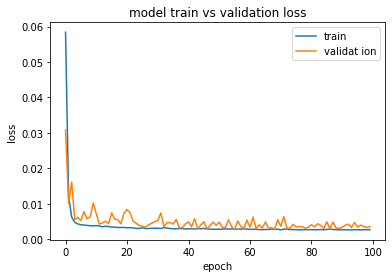

In [ ]:
file_name = 'result_' + model_name
file_name = 'loss_' + model_name
file_path = 'images/loss/{}.png'.format(file_name)
if not os.path.exists(os.path.dirname(file_path)):
    try:
        os.makedirs(os.path.dirname(file_path))
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validat ion'], loc='upper right')
plt.savefig(file_path)

#https://keras.io/api/layers/recurrent_layers/
##https://www.parenting.com.tw/article/5080961-/
##https://wenwu53.medium.com/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E8%87%AA%E5%AD%B8%E7%AD%86%E8%A8%9809-keras2-0-3e5c9ac1658f


#回測。跟歷史比較結果如何?

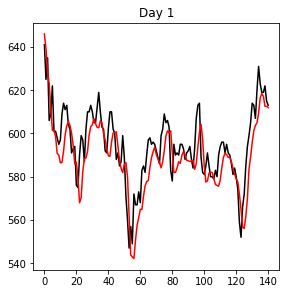

In [ ]:
def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data

# 回復預測資料值為原始數據的規模
train_predict = inverse_normalize_data(train_predict, scaler)
x_train = inverse_normalize_data(x_train, scaler)
y_train = inverse_normalize_data(y_train, scaler)
validate_predict = inverse_normalize_data(validate_predict, scaler)
y_validate = inverse_normalize_data(y_validate, scaler)
test_predict = inverse_normalize_data(test_predict, scaler)


# plot predict situation (save in images/result)
file_name = 'result_' + model_name
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(231)

ax1.plot(y_validate[:, 0, 3], color='black')
ax1.plot(validate_predict[:, 0, 3], color='red')
ax1.title.set_text("Day 1")


#第三個聖盃：來預測一下明天的股價吧!

In [ ]:
# 3 or 0: close 的位置, 0:5為五天
ans = np.append(y_validate[-1, -1, 3], test_predict[-1, 0:5, 3])
output=[]
output.append(ans)
print(df_2330["date"].iloc[-1]+"收盤價:", output[0][0])
print("隔天收盤價:", output[0][1])

2021-09-14收盤價: 613.0
隔天收盤價: 610.970947265625


#準不準? 可以多學幾個欄位

In [ ]:
import requests
import pandas as pd
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
    "dataset": "TaiwanStockPrice",
    "data_id": "0050",
    "start_date": "2018-09-26",
    "end_date": "2021-09-26",
    "token": "", # 參考登入，獲取金鑰
}
resp = requests.get(url, params=parameter)
data = resp.json()
df_0050 = pd.DataFrame(data["data"])
print(df_0050.head())

         date stock_id  Trading_Volume  ...  close  spread  Trading_turnover
0  2018-09-26     0050         8036503  ...  86.90   -0.20              2692
1  2018-09-27     0050        27800036  ...  87.35    0.45              8114
2  2018-09-28     0050        13202371  ...  86.90   -0.45              4328
3  2018-10-01     0050         5914234  ...  87.35    0.45              2729
4  2018-10-02     0050         5434332  ...  86.05   -1.30              2466

[5 rows x 10 columns]


In [ ]:
df_0050=df_0050.rename(columns={"close":"0050"})

In [ ]:
#加在右邊
df_all=df_2330.join(df_0050['0050'])
print(df_all)

           date stock_id  Trading_Volume  ...  spread  Trading_turnover    0050
0    2018-09-26     2330        25061115  ...     0.0              7007   86.90
1    2018-09-27     2330        38495371  ...     1.5             11536   87.35
2    2018-09-28     2330        39645486  ...    -2.5             13060   86.90
3    2018-10-01     2330        22409380  ...     0.5             11914   87.35
4    2018-10-02     2330        38391491  ...    -5.5             17095   86.05
..          ...      ...             ...  ...     ...               ...     ...
720  2021-09-08     2330        38713621  ...    -4.0             38267  140.65
721  2021-09-09     2330        19309522  ...     0.0             19569  140.30
722  2021-09-10     2330        16740439  ...     3.0             17067  141.95
723  2021-09-13     2330        15809768  ...    -7.0             21779  141.45
724  2021-09-14     2330        16024935  ...    -2.0             13569  141.60

[725 rows x 11 columns]
